In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [3]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(
    n_samples=3000,
    centers=NUM_CLASSES,
    cluster_std=1.5,
    n_features=NUM_FEATURES,
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_train_blob, X_test_blob, y_train_blob, y_test_blob = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)


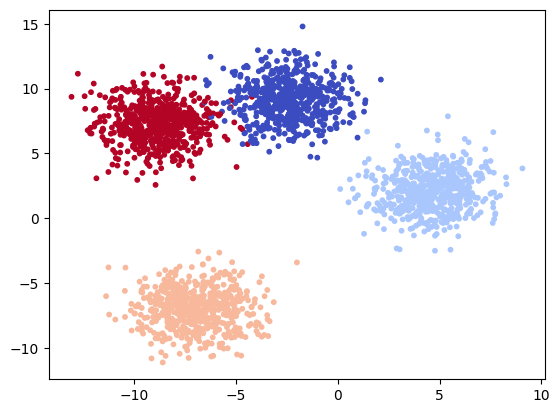

In [4]:
plt.scatter(X_train_blob[:, 0], X_train_blob[:, 1], c=y_train_blob, cmap='coolwarm', s=10)
plt.show()

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [6]:
class BlobModel(torch.nn.Module):
    def __init__(self, input_features, output_features, hidden_units=16):
        super().__init__()
        self.linear_layer_stack = torch.nn.Sequential(
            torch.nn.Linear(in_features=input_features, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [8]:
model_blob = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=16
).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_blob.parameters(), lr=0.001)

In [9]:
model_blob.eval()
with torch.inference_mode():
    y_logits_blob = model_blob(X_test_blob.to(device))
    y_pred_blob = torch.argmax(y_logits_blob, dim=1)

In [10]:
y_pred_blob[:10], y_test_blob[:10]

(tensor([0, 2, 2, 0, 0, 0, 3, 2, 2, 2]),
 tensor([2., 0., 0., 1., 3., 1., 1., 0., 3., 0.]))

### Training loop

In [11]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

n_epochs = 1000
X_train_blob = X_train_blob.to(device)
y_train_blob = y_train_blob.to(device)

X_test_blob = X_test_blob.to(device)
y_test_blob = y_test_blob.to(device)

In [13]:
# Loop through epochs
for epoch in range(n_epochs):
    model_blob.train()

    # Forward pass
    y_logits_blob = model_blob(X_train_blob)
    y_pred_blob = torch.softmax(y_logits_blob, dim=1).argmax(dim=1)

    # Calculate loss
    loss = loss_fn(y_logits_blob, y_train_blob.type(torch.long))
    acc = (y_pred_blob == y_train_blob).sum() / len(y_pred_blob)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backward pass
    loss.backward() 
    
    # Optimizer step
    optimizer.step()

    model_blob.eval()
    with torch.inference_mode():
        y_logits_blob_test = model_blob(X_test_blob)
        y_pred_blob_test = torch.softmax(y_logits_blob_test, dim=1).argmax(dim=1)

        loss_test = loss_fn(y_logits_blob_test, y_test_blob.type(torch.long))
        acc_test = (y_pred_blob_test == y_test_blob).sum() / len(y_pred_blob_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | "
              f"Test Loss: {loss_test:.5f} | Test Accuracy: {acc_test:.2f}")
print("Training complete.")

Epoch: 0 | Loss: 1.43823 | Accuracy: 0.01 | Test Loss: 1.42990 | Test Accuracy: 0.01
Epoch: 100 | Loss: 1.27514 | Accuracy: 0.36 | Test Loss: 1.27052 | Test Accuracy: 0.37
Epoch: 200 | Loss: 1.14276 | Accuracy: 0.58 | Test Loss: 1.13985 | Test Accuracy: 0.57
Epoch: 300 | Loss: 1.01803 | Accuracy: 0.70 | Test Loss: 1.01571 | Test Accuracy: 0.68
Epoch: 400 | Loss: 0.89881 | Accuracy: 0.79 | Test Loss: 0.89636 | Test Accuracy: 0.77
Epoch: 500 | Loss: 0.78545 | Accuracy: 0.90 | Test Loss: 0.78256 | Test Accuracy: 0.90
Epoch: 600 | Loss: 0.67663 | Accuracy: 0.94 | Test Loss: 0.67321 | Test Accuracy: 0.95
Epoch: 700 | Loss: 0.57492 | Accuracy: 0.97 | Test Loss: 0.57096 | Test Accuracy: 0.96
Epoch: 800 | Loss: 0.48364 | Accuracy: 0.98 | Test Loss: 0.47931 | Test Accuracy: 0.98
Epoch: 900 | Loss: 0.40606 | Accuracy: 0.98 | Test Loss: 0.40164 | Test Accuracy: 0.98
Training complete.


In [17]:
# # !pip install -U torchmetrics
# from torchmetrics import Accuracy, Precision, Recall, F1Score
# accuracy = Accuracy().to(device)
# precision = Precision(num_classes=NUM_CLASSES, average='macro').to(device)
# recall = Recall(num_classes=NUM_CLASSES, average='macro').to(device)
# f1 = F1Score(num_classes=NUM_CLASSES, average='macro').to(device)

# train_acc = accuracy(y_pred_blob, y_train_blob.type(torch.long))
# test_acc = accuracy(y_pred_blob_test, y_test_blob.type(torch.long))
# test_precision = precision(y_pred_blob_test, y_test_blob.type(torch.long))
# test_recall = recall(y_pred_blob_test, y_test_blob.type(torch.long))
# test_f1 = f1(y_pred_blob_test, y_test_blob.type(torch.long))
# print(f"Train Accuracy: {train_acc:.2f}")
# print(f"Test Accuracy: {test_acc:.2f}")
# print(f"Test Precision: {test_precision:.2f}")
# print(f"Test Recall: {test_recall:.2f}")
# print(f"Test F1 Score: {test_f1:.2f}")